###Toy Model
We implement an illustrative toy model to provide intuition for pymc.MCMC sampling procedures.

Define variables:
$$ \theta = (home, intercept) $$
$$ y =  (y_{home} , y_{away} ) $$

Define Distributions:

$$ y_{home} | \theta \sim Poisson( exp(home + intercept) ) $$
$$ y_{away} | \theta \sim Poisson( exp(intercept) ) $$
$$ home \sim N(0,1000) $$
$$ intercept \sim N(0,1000) $$

Using Bayes rule:

$$ P(\theta | y) \propto P(y | \theta) P(\theta) $$
$$ P(\theta | y) \propto P(y_{home} | \theta) P(y_{intercept} | \theta) P(home) P(intercept) $$



In [1]:
%matplotlib inline
from scipy.stats import norm
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def log_pHome(home):
    return norm.logpdf(home,loc=0.,scale=1000.)

def log_pIntercept(home):
    return norm.logpdf(home,loc=0.,scale=1000.)

def log_p_Y_away_given_theta(y_away,home,intercept):
    return np.sum(poisson.logpmf(y_away,np.exp(intercept)))

def log_p_Y_home_given_theta(y_home,home,intercept):
    return np.sum(poisson.logpmf(y_home,np.exp(home + intercept)))

def log_posterior(y_home,y_away,home_0,intercept_0):
    return log_p_Y_home_given_theta(y_home,home_0,intercept_0) + \
            log_p_Y_away_given_theta(y_away,home_0,intercept_0) + \
            log_pHome(home_0) + log_pIntercept(intercept_0)


In [3]:
#Illustrative goals data
y_home = np.array([1,2,4,0,5])
y_away = np.array([2,3,4,1,0])

In [8]:
def MH(logpdf, X0, sigma, y_home,y_away, sample_size=20000,burnin=1000,thin=5):
    acc = 0.0
    result = np.zeros((thin*sample_size+burnin,2))
    r = np.random.random(thin*sample_size+burnin)
    for i in xrange(thin*sample_size+burnin):
        if np.mod(i,2)==1:
            x0 = np.random.normal(X0[0], sigma)
            p = logpdf(y_home,y_away,x0,X0[1])-logpdf(y_home,y_away,X0[0],X0[1])
            if np.log(r[i]) < p:
                acc += 1
                X0[0] = x0
                result[i] = X0
        if np.mod(i,2)==0:       
            x1 = np.random.normal(X0[1], sigma)
            p = logpdf(y_home,y_away,X0[0],x1)-logpdf(y_home,y_away,X0[0],X0[1])
            if np.log(r[i]) < p:
                acc += 1
                X0[1] = x1
                result[i] = X0
    print "Acceptance ratio is "+str(acc/(thin*sample_size))+"."
    return result[burnin::thin]

# autocorrelation with lag t
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# effective sample size
def neff(x, T):
    n = len(x)
    rho = 1.0
    for i in xrange(T):
        rho += 2*rhot(x, i+1)
    return n/rho

In [11]:
sigma=1.
X0 = [np.log(0.8),np.log(1.5)]
mh_samples = MH(log_posterior, X0, sigma, y_home,y_away)


Acceptance ratio is 0.29984.


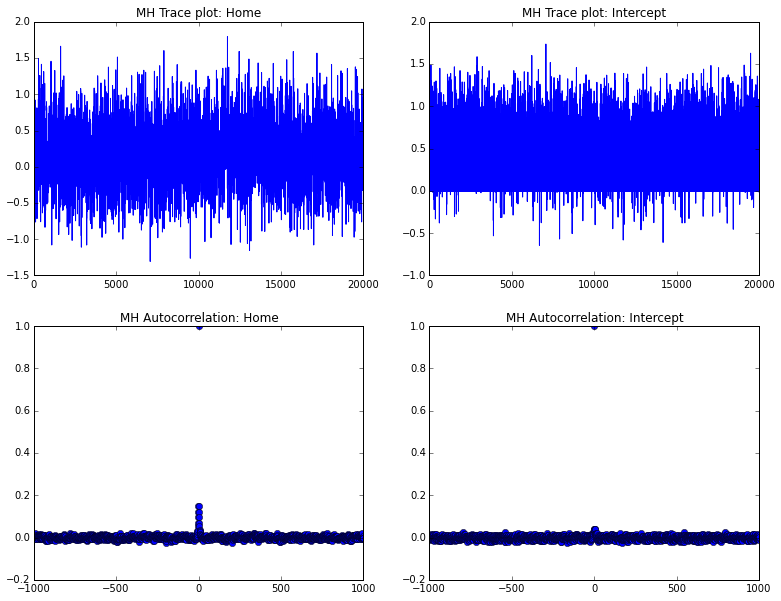

In [12]:
f, axarr = plt.subplots(2,2, figsize=(13,10))
axarr[0][0].plot(mh_samples[:,0])
axarr[0][0].set_title("MH Trace plot: Home " )

axarr[0][1].plot(mh_samples[:,1])
axarr[0][1].set_title("MH Trace plot: Intercept " )


axarr[1][0].acorr(mh_samples[:,0] - np.mean(mh_samples[:,0]), normed=True, usevlines=False, maxlags=1000)
axarr[1][0].set_title("MH Autocorrelation: Home")

axarr[1][1].acorr(mh_samples[:,1] - np.mean(mh_samples[:,1]), normed=True, usevlines=False, maxlags=1000)
axarr[1][1].set_title("MH Autocorrelation: Intercept")

In [16]:
print "Mean home and intercept", np.mean(mh_samples[:,0]), np.mean(mh_samples[:,1])

Mean home and intercept 0.0565295976003 0.188844926931
